In [47]:
%pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

C:\Users\oicmy\AppData\Local\Temp\ipykernel_54652\1341870611.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
file_path = '215d3c1ea7d0c562774a8c6e4b157ac0.xlsx'
data = pd.ExcelFile(file_path)

In [3]:
data.sheet_names

['2022']

In [4]:
df = data.parse('2022')

In [5]:
columns_to_extract = [
    "Odczyn pH - wartość terenowa",
    "Temperatura - wartość terenowa [°C]",
]

start_column = "Ogólny węgiel organiczny [mgC/l]"
end_column = df.columns[-2]

columns_for_mineralization = df.loc[:, start_column:end_column]

columns_for_mineralization = columns_for_mineralization.replace({',': '.'}, regex=True)
columns_for_mineralization = columns_for_mineralization.replace({r'[<>]': ''}, regex=True)
columns_for_mineralization = columns_for_mineralization.apply(pd.to_numeric, errors='coerce')

In [6]:
columns_for_mineralization.head()

,Ogólny węgiel organiczny [mgC/l],Amonowy jon [mgNH4/l],Antymon [mgSb/l],Arsen [mgAs/l],Azotany [mgNO3/l],Azotyny [mgNO2/l],Bar [mgBa/l],Beryl [mgBe/l],Bor [mgB/l],Chlorki [mgCl/l],...,Siarczany [mgSO4/l],Sód [mgNa/l],Srebro [mgAg/l],Tal [mgTl/l],Tytan [mgTi/l],Uran [mgU/l],Wanad [mgV/l],Wapń [mgCa/l],Wodorowęglany [mgHCO3/l],Żelazo [mgFe/l]
0,14.0,1.04,0.00005,0.002,0.65,0.66,0.109,0.00005,0.10,332.0,...,34.60,204.7,0.00005,0.00005,0.003,0.00005,0.003,98.8,357.0,0.77
1,2.0,0.50,0.00005,0.002,0.19,0.04,0.073,0.00005,0.06,51.2,...,84.20,21.8,0.00005,0.00005,0.002,0.00005,0.001,99.5,244.0,1.85
2,2.0,1.13,0.00005,0.002,0.72,1.42,0.021,0.00005,1.00,800.0,...,6.95,622.7,0.00005,0.00005,0.002,0.00005,0.005,20.0,379.0,0.11
3,1.9,5.58,0.00005,0.002,0.05,0.06,0.276,0.00005,0.26,448.0,...,61.60,292.3,0.00005,0.00005,0.002,0.00005,0.002,105.5,467.0,1.54
4,15.0,3.51,0.00005,0.002,0.11,0.01,0.023,0.00005,0.10,19.5,...,7.47,15.1,0.00005,0.00005,0.002,0.00005,0.001,89.5,360.0,0.02


In [7]:
df_selected = df[columns_to_extract]

df_selected = df_selected.replace({',': '.'}, regex=True)
df_selected = df_selected.apply(pd.to_numeric, errors='coerce')

df_selected.columns = [
    "ph_field",
    "temp_field",
]

In [14]:
df_selected["mineralization"] = columns_for_mineralization.sum(axis=1)

In [15]:
range_column = "Przedział ujętej warstwy wodonośnej [m p.p.t.]"
range_data = df[range_column].dropna()

def calculate_mean_range(range_str):
    try:
        min_val, max_val = map(float, range_str.replace(',', '.').split('-'))
        return (min_val + max_val) / 2
    except Exception:
        return None

df_selected["depth"] = range_data.apply(calculate_mean_range)

In [16]:
df_selected.head()

,ph_field,temp_field,mineralization,depth
0,7.14,11.7,1063.71434,14.0
1,7.19,11.5,522.47648,28.0
2,7.76,11.7,1850.88460,45.0
3,7.51,12.1,1436.56268,27.1
4,7.15,10.0,539.03194,28.0


In [53]:
file_path = 'cities_locations.xlsx'
cities_coordinates = pd.ExcelFile(file_path)

In [54]:
cities_coordinates.sheet_names

['Sheet1']

In [55]:
cities_coordinates_df = cities_coordinates.parse('Sheet1')

In [56]:
cities_coordinates_df.head()

,City,Region,Latitude,Longitude
0,Świnoujście,Świnoujście,53.904445,14.266023
1,Świnoujście,Świnoujście,53.904445,14.266023
2,Świnoujście,Świnoujście,53.904445,14.266023
3,Świnoujście,Świnoujście,53.904445,14.266023
4,Świnoujście,Świnoujście,53.904445,14.266023


In [60]:
df_selected = pd.concat([df_selected, cities_coordinates_df], axis=1)

In [61]:
df_selected.head()

,ph_field,temp_field,mineralization,depth,ph_class,City,Region,Latitude,Longitude
0,7.14,11.7,1063.71434,14.0,normal,Świnoujście,Świnoujście,53.904445,14.266023
1,7.19,11.5,522.47648,28.0,normal,Świnoujście,Świnoujście,53.904445,14.266023
2,7.76,11.7,1850.88460,45.0,alkalite,Świnoujście,Świnoujście,53.904445,14.266023
3,7.51,12.1,1436.56268,27.1,alkalite,Świnoujście,Świnoujście,53.904445,14.266023
4,7.15,10.0,539.03194,28.0,normal,Świnoujście,Świnoujście,53.904445,14.266023


In [62]:
def plot_histogram(dataFrame):
  fig, axes = plt.subplots(2, 2, figsize=(12, 10))

  for ax, column in zip(axes.flatten(), dataFrame.columns):
      counts, bins, patches = ax.hist(dataFrame[column].dropna(), bins=30, edgecolor='black', alpha=0.7)

      for count, bin_patch in zip(counts, patches):
          x_pos = bin_patch.get_x() + bin_patch.get_width() / 2  # Center text
          ax.text(x_pos, count, str(int(count) if count != 0 else ''), ha='center', va='bottom', fontsize=10)

      # ax.hist(df_selected[column].dropna(), bins=30, edgecolor='black', alpha=0.7, histtype='step')
      ax.set_title(f"Histogram of {column}")
      ax.set_xlabel(column)
      ax.set_ylabel("Frequency")
      ax.grid(True)

  plt.tight_layout()
  plt.show()

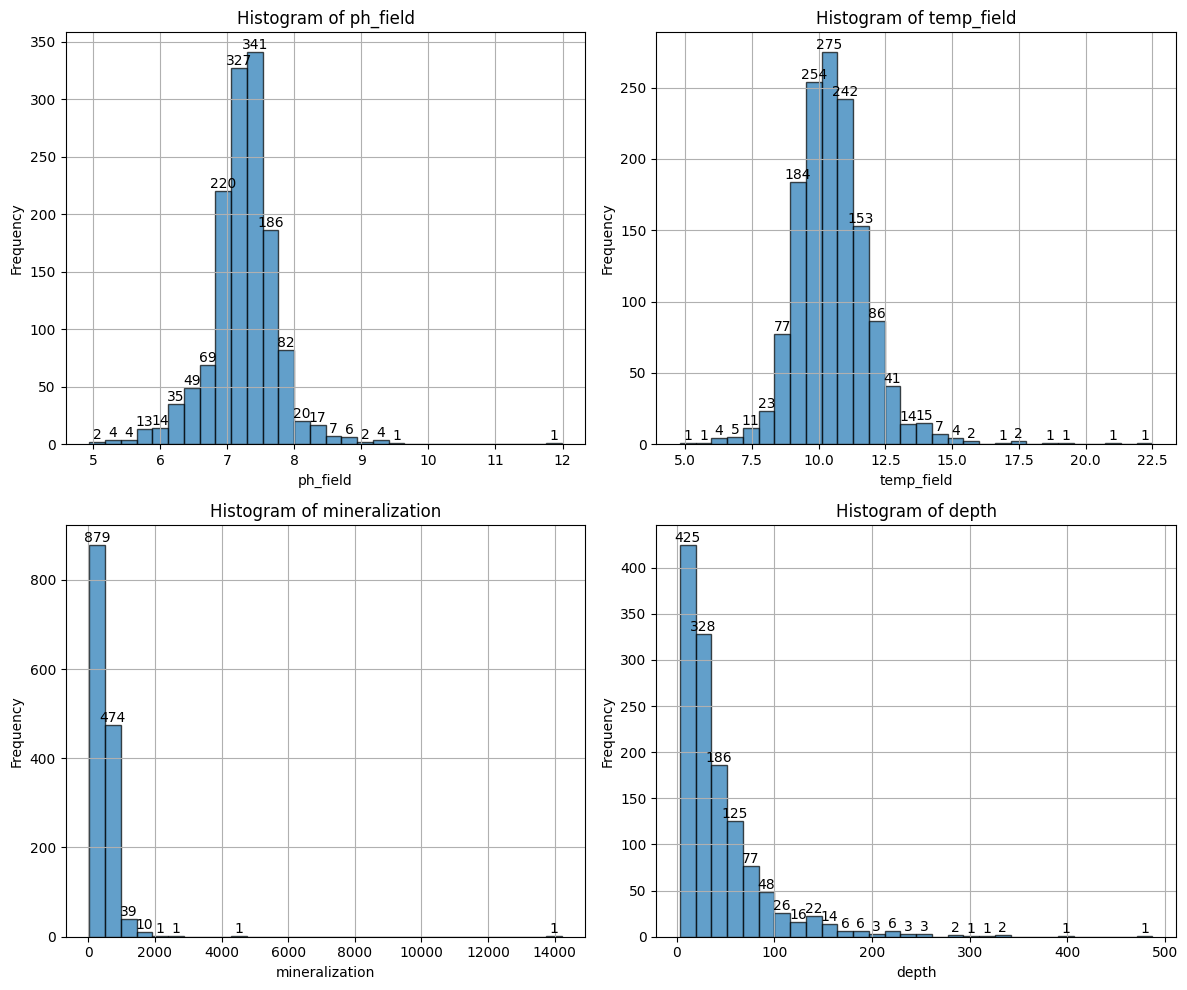

In [63]:
plot_histogram(df_selected)

In [64]:
thresholds = {'ph_field': 10, 'temp_field': 20.0, 'mineralization': 3000, 'depth': 375}

df_without_edge_values = df_selected.copy()

for column, threshold_value in thresholds.items():
    if column in df_without_edge_values.columns:
        df_without_edge_values = df_without_edge_values[df_without_edge_values[column] <= threshold_value]

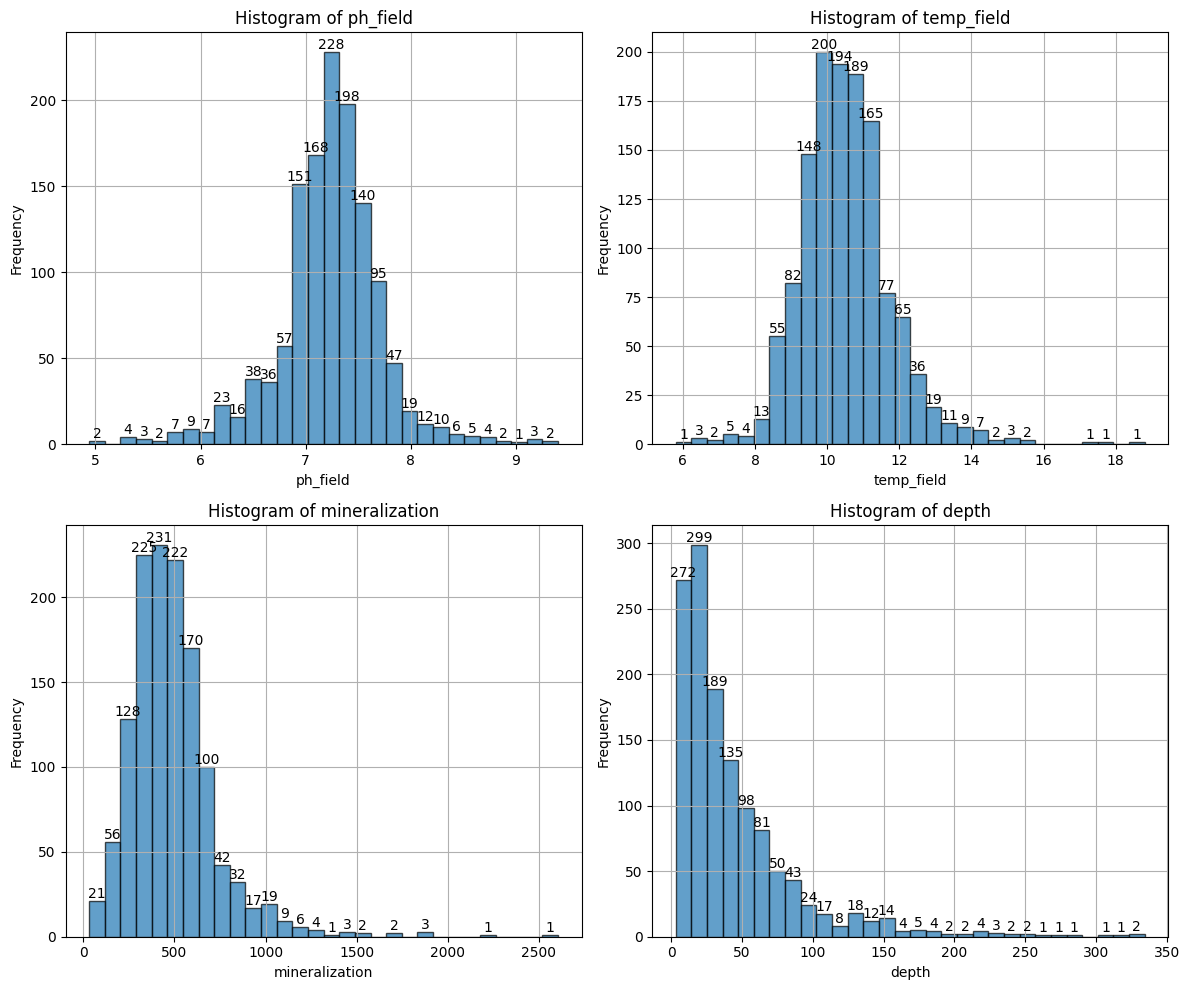

In [65]:
plot_histogram(df_without_edge_values)

pousuwac niektore skrajne wartosci, zeby poprawic skale
- im glebiej temperatura wieksza
- powyzej -> to wtedy mineralizacja wieksza
-

In [66]:
def find_outliers(data, k, r):
    n = len(data)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = np.sqrt(np.sum((data[i] - data[j]) ** 2))

    sorted_indices = np.argsort(dist_matrix, axis=1)
    k_closest_indices = sorted_indices[:, 1:k+1]
    max_distances = np.zeros(n)

    for i in range(n):
        max_distances[i] = max(dist_matrix[i, k_closest_indices[i]])

    sorted_max_distances = np.sort(max_distances)
    threshold_index = int((1 - r) * n)
    threshold = sorted_max_distances[threshold_index]

    outliers = np.where(max_distances > threshold)[0]

    return outliers, max_distances

In [67]:
components = ['ph_field', 'temp_field', 'mineralization', 'depth']

def find_outlier_sets(dataframe, k, r):
  outlier_sets = []
  for component in components:
    outliers, max_distances = find_outliers(dataframe[component], k, r)
    # print(outliers)
    # print(len(outliers))
    outlier_sets.append(set(outliers))

  return outlier_sets

outlier_sets = find_outlier_sets(df_selected, k=10, r=0.5)

common_outliers = set.intersection(*outlier_sets)
print("Common Outliers:", common_outliers)
print("Number of Common Outliers:", len(common_outliers))

Common Outliers: {641, 69, 987, 1160, 377, 938, 204, 78, 368, 849, 53, 475, 535, 216, 1305, 1051, 1182, 286}
Number of Common Outliers: 18


In [68]:
outliers, max_distances = find_outliers(df_selected['ph_field'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[ 132  862  985  987 1029 1044 1132 1157 1275 1305 1345 1355]
12


In [69]:
outliers, max_distances = find_outliers(df_selected['temp_field'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[ 165  643  658  819  821  849  938 1026 1161 1164 1175 1199 1241 1374]
14


In [70]:
outliers, max_distances = find_outliers(df_selected['mineralization'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[   2   63   69  104  159  216  407  580  651  663 1017 1114 1199 1273]
14


In [71]:
outliers, max_distances = find_outliers(df_selected['depth'], k=10, r=0.01)
print(outliers)
print(len(outliers))

[]
0


In [74]:
def calculate_and_plot_outliers(dataframe, components, outlier_sets, k, r):
  for component, outliers in zip(components, outlier_sets):
      print(f'k = {k}, r = {r}, {len(outliers)}: {outliers}')

      y_values = np.zeros(len(dataframe[component]))
      plt.plot(dataframe[component], y_values, '|', label='Data', alpha=0.5)
      plt.plot(dataframe[component].iloc[list(outliers)], y_values[list(outliers)], '|', label='Outliers')
      plt.title(f"Plot of {component} with detected outliers")
      plt.xlabel("X Values")
      plt.ylabel("Y values")
      plt.legend()
      plt.show()

k = 10, r = 0.01, 631: {2, 3, 8, 9, 11, 12, 14, 30, 31, 34, 42, 43, 45, 50, 52, 53, 58, 60, 62, 65, 66, 69, 71, 74, 76, 77, 78, 79, 80, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 107, 109, 111, 112, 113, 114, 115, 116, 120, 123, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 138, 139, 142, 143, 146, 148, 149, 157, 159, 174, 179, 180, 188, 192, 198, 199, 200, 201, 204, 207, 216, 219, 221, 223, 224, 225, 227, 228, 229, 230, 235, 237, 239, 243, 245, 247, 248, 249, 250, 251, 252, 256, 257, 258, 259, 260, 261, 263, 265, 266, 268, 269, 270, 271, 277, 281, 283, 286, 287, 289, 291, 296, 297, 298, 299, 301, 302, 303, 304, 307, 308, 311, 313, 316, 318, 319, 321, 324, 326, 327, 328, 329, 330, 333, 335, 336, 337, 339, 342, 344, 346, 347, 349, 351, 352, 354, 356, 359, 361, 366, 367, 368, 369, 371, 377, 378, 381, 382, 383, 389, 390, 392, 395, 400, 402, 405, 408, 410, 413, 415, 417, 420, 425, 427, 431, 433, 435, 437, 441, 442, 449, 454, 457, 4

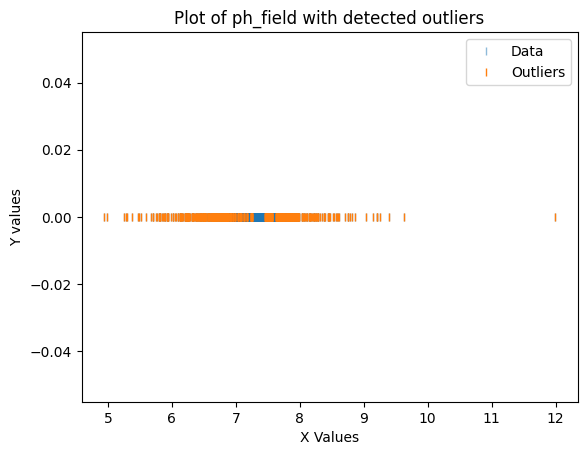

k = 10, r = 0.01, 147: {513, 1026, 1039, 16, 528, 530, 1044, 21, 534, 535, 1051, 1053, 1061, 557, 53, 578, 579, 580, 69, 582, 1097, 1098, 1099, 78, 594, 1106, 596, 88, 1115, 616, 618, 109, 624, 626, 1142, 122, 1151, 1152, 641, 1153, 643, 1154, 1155, 1160, 1161, 1164, 142, 658, 1170, 660, 1175, 1182, 160, 164, 165, 168, 1194, 1197, 1199, 176, 180, 693, 1212, 189, 194, 195, 196, 197, 204, 720, 1233, 722, 1234, 726, 216, 217, 1241, 1242, 1251, 742, 249, 768, 258, 260, 1284, 780, 273, 1299, 793, 1305, 1307, 286, 289, 802, 803, 1319, 1320, 298, 812, 1328, 306, 819, 820, 821, 822, 827, 316, 1347, 836, 1350, 841, 1358, 849, 1370, 347, 348, 1373, 1374, 1375, 1376, 1378, 1379, 1380, 869, 1385, 368, 1392, 1397, 1398, 377, 1402, 380, 390, 392, 394, 911, 419, 938, 431, 944, 947, 955, 475, 987, 997, 998, 1004}


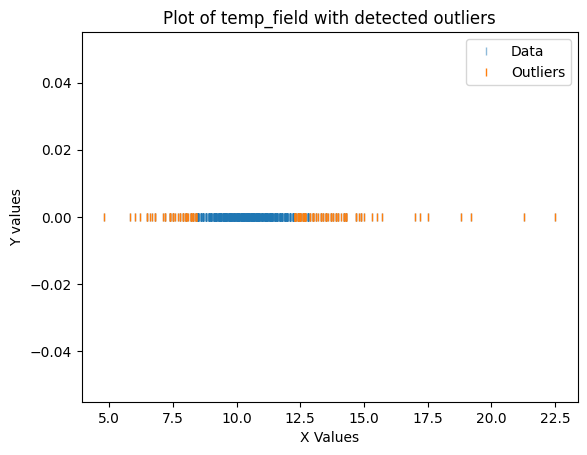

k = 10, r = 0.01, 702: {0, 1, 2, 3, 5, 6, 9, 11, 12, 16, 19, 20, 21, 22, 23, 25, 26, 28, 31, 36, 37, 38, 46, 47, 52, 53, 63, 65, 67, 68, 69, 73, 74, 78, 79, 81, 82, 83, 91, 94, 98, 100, 102, 104, 108, 109, 110, 114, 115, 117, 121, 125, 126, 128, 131, 135, 136, 137, 138, 139, 140, 141, 143, 145, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 162, 163, 165, 166, 167, 169, 170, 171, 182, 185, 187, 191, 192, 193, 196, 197, 203, 204, 205, 207, 209, 211, 212, 213, 215, 216, 217, 221, 223, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 239, 240, 243, 244, 247, 250, 255, 256, 258, 259, 261, 264, 265, 266, 270, 272, 274, 275, 277, 278, 279, 280, 283, 284, 286, 289, 290, 296, 303, 306, 307, 310, 311, 312, 313, 317, 319, 325, 328, 329, 331, 334, 335, 341, 342, 344, 350, 351, 352, 353, 358, 360, 362, 363, 365, 366, 367, 368, 370, 371, 372, 373, 377, 379, 380, 381, 384, 387, 389, 390, 391, 392, 393, 396, 397, 400, 403, 404, 405, 407, 408, 409, 413, 414, 416, 419, 420, 421, 422, 424, 426, 427,

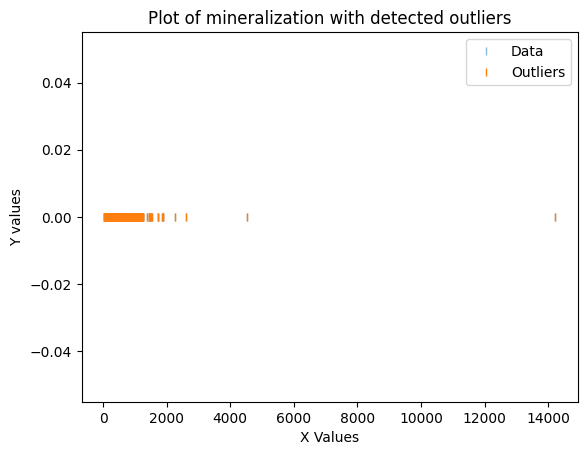

k = 10, r = 0.01, 589: {7, 17, 21, 22, 29, 31, 40, 42, 45, 46, 52, 53, 55, 56, 65, 66, 67, 69, 70, 72, 76, 78, 79, 80, 86, 87, 88, 89, 92, 93, 94, 96, 97, 103, 107, 110, 111, 112, 113, 114, 115, 116, 119, 120, 124, 126, 134, 138, 139, 143, 147, 151, 153, 154, 157, 158, 162, 163, 164, 165, 166, 167, 168, 169, 176, 178, 179, 180, 181, 183, 185, 187, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 203, 204, 205, 207, 208, 209, 210, 213, 214, 216, 220, 226, 231, 232, 235, 242, 245, 247, 248, 252, 254, 260, 264, 265, 271, 272, 273, 277, 278, 282, 283, 284, 285, 286, 291, 292, 293, 294, 296, 297, 299, 301, 305, 307, 310, 314, 319, 320, 323, 324, 329, 330, 335, 336, 337, 339, 340, 345, 346, 347, 348, 349, 350, 353, 355, 356, 358, 360, 361, 362, 365, 368, 369, 371, 375, 376, 377, 379, 387, 388, 397, 398, 399, 402, 404, 405, 406, 407, 416, 420, 423, 425, 430, 431, 434, 436, 438, 443, 444, 446, 447, 448, 449, 451, 456, 457, 459, 463, 464, 465, 467, 468, 470, 471, 473, 474, 475, 476, 479, 480, 

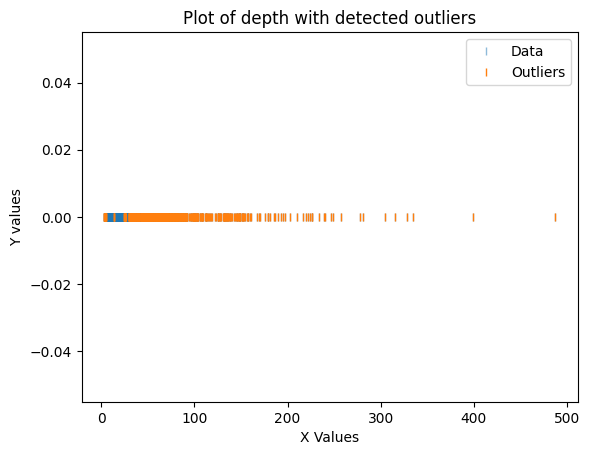

In [75]:
calculate_and_plot_outliers(df_selected, components, outlier_sets, k=10, r=0.01)

standaryzacja/normalizacja

## Outliers after removing the most edge values

In [77]:
df_without_edge_values = df_without_edge_values.reset_index(drop=True)
cleaned_outlier_sets = find_outlier_sets(df_without_edge_values, k=10, r=0.02)

k = 10, r = 0.02, 24: {130, 1291, 1050, 815, 951, 1208, 1082, 831, 964, 1222, 1101, 1230, 465, 982, 988, 95, 1250, 1002, 1262, 111, 241, 1268, 1013, 761}


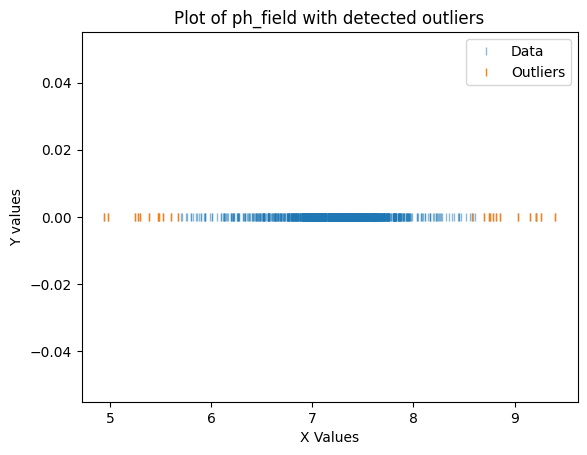

k = 10, r = 0.02, 25: {776, 1288, 906, 794, 283, 1051, 671, 800, 161, 1057, 419, 1066, 820, 698, 190, 191, 704, 838, 719, 986, 1114, 1002, 1006, 1008, 754}


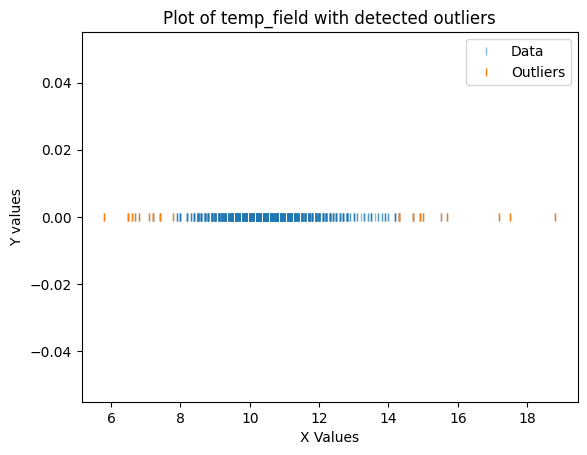

k = 10, r = 0.02, 25: {2, 3, 643, 394, 12, 396, 398, 1165, 155, 1055, 1063, 1065, 564, 1206, 1213, 68, 80, 210, 853, 215, 102, 1002, 107, 1143, 632}


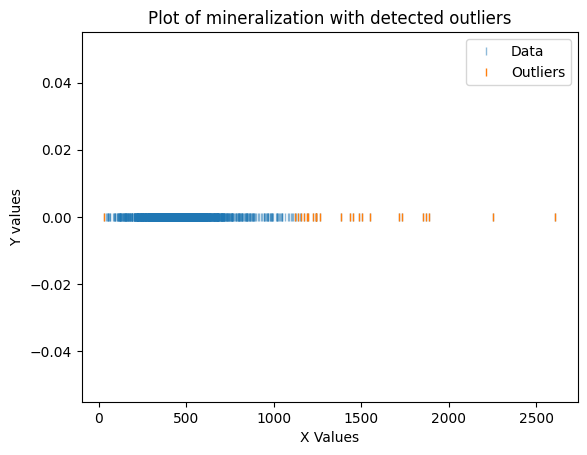

k = 10, r = 0.02, 25: {640, 130, 520, 648, 652, 271, 660, 1177, 923, 158, 820, 952, 837, 839, 846, 1104, 339, 1114, 95, 361, 109, 111, 112, 1009, 1279}


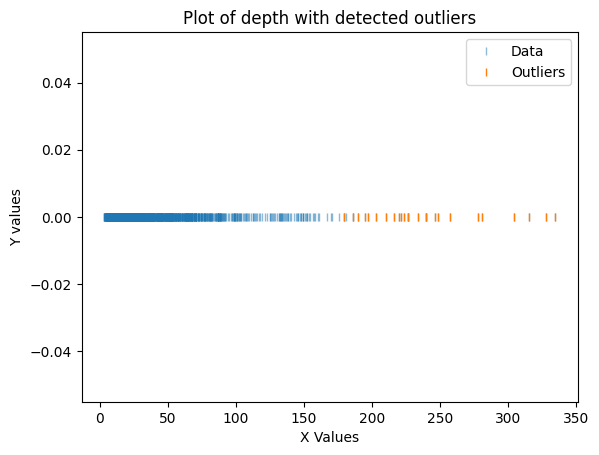

In [78]:
calculate_and_plot_outliers(df_without_edge_values, components, cleaned_outlier_sets, k=10, r=0.02)

## Standarization

In [101]:
columns = df_selected.columns
columns_to_remove = ['City', 'Region', 'Latitude', 'Longitude', 'ph_class']
columns_to_scale = [col for col in columns if col not in columns_to_remove]
df_selected.shape

(1406, 9)

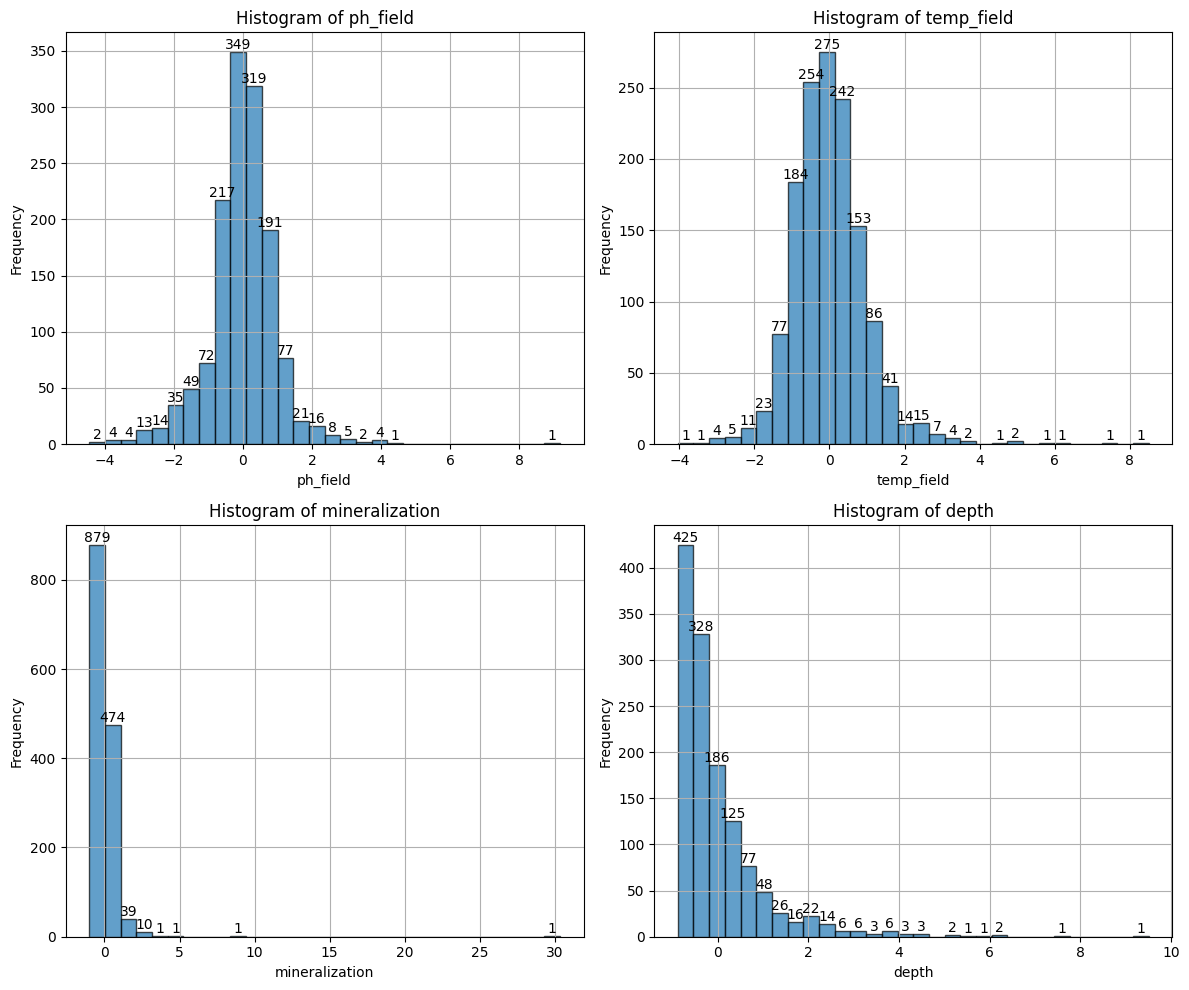

,ph_field,temp_field,mineralization,depth
0,-0.196699,0.849036,1.265880,-0.643905
1,-0.099968,0.707261,0.069204,-0.343604
2,1.002758,0.849036,3.006311,0.021047
3,0.519106,1.132586,2.090247,-0.362909
4,-0.177353,-0.356051,0.105808,-0.343604


In [110]:
scaler = StandardScaler()

df_standardized = pd.DataFrame(scaler.fit_transform(df_selected[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_standardized)
df_standardized.head()

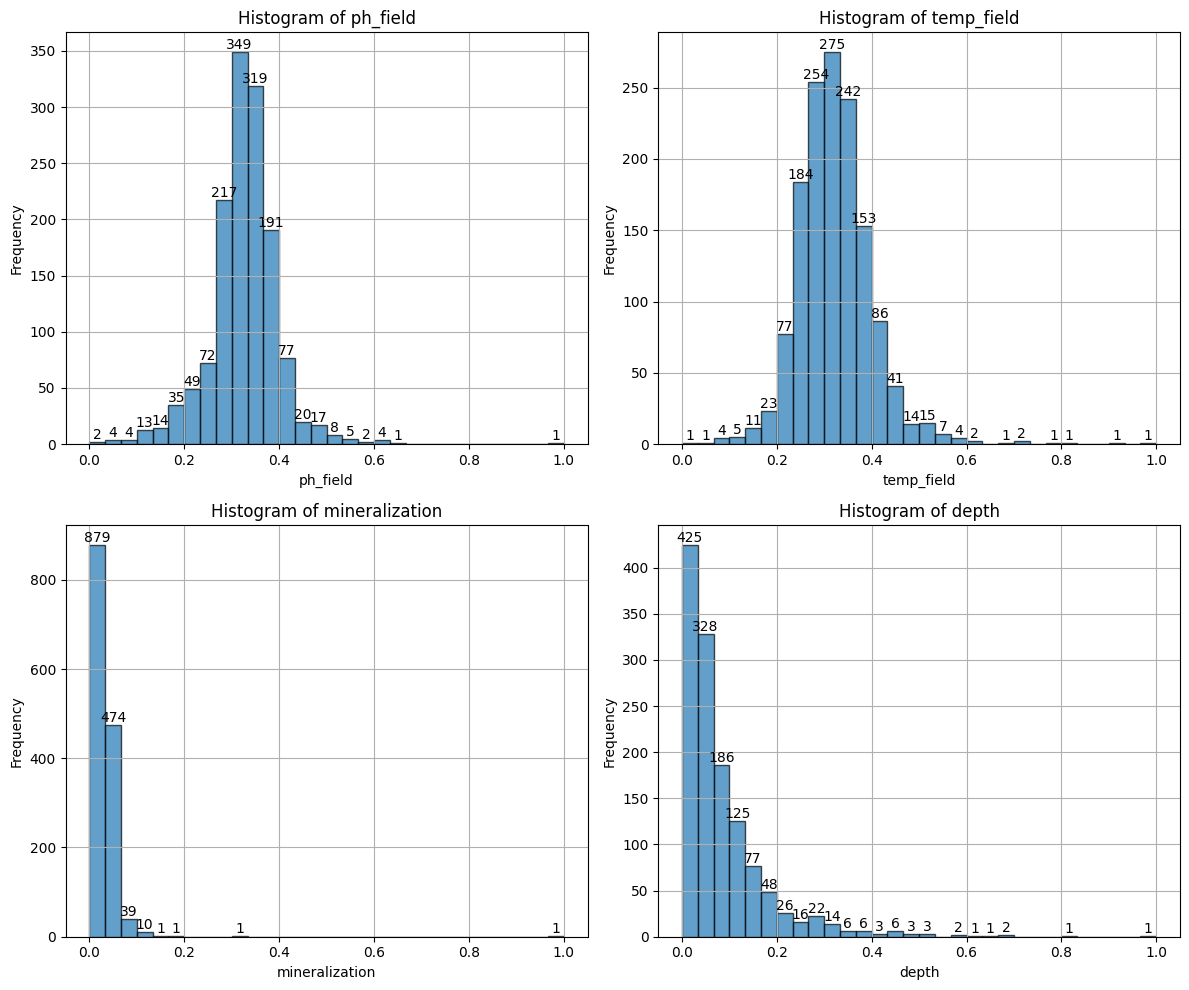

,ph_field,temp_field,mineralization,depth
0,0.312057,0.389831,0.072789,0.022716
1,0.319149,0.378531,0.034620,0.051626
2,0.400000,0.389831,0.128301,0.086732
3,0.364539,0.412429,0.099082,0.049768
4,0.313475,0.293785,0.035788,0.051626


In [109]:
scaler = MinMaxScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df_selected[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_normalized)
df_normalized.head()

In [111]:
df_without_edge_values.shape

(1295, 9)

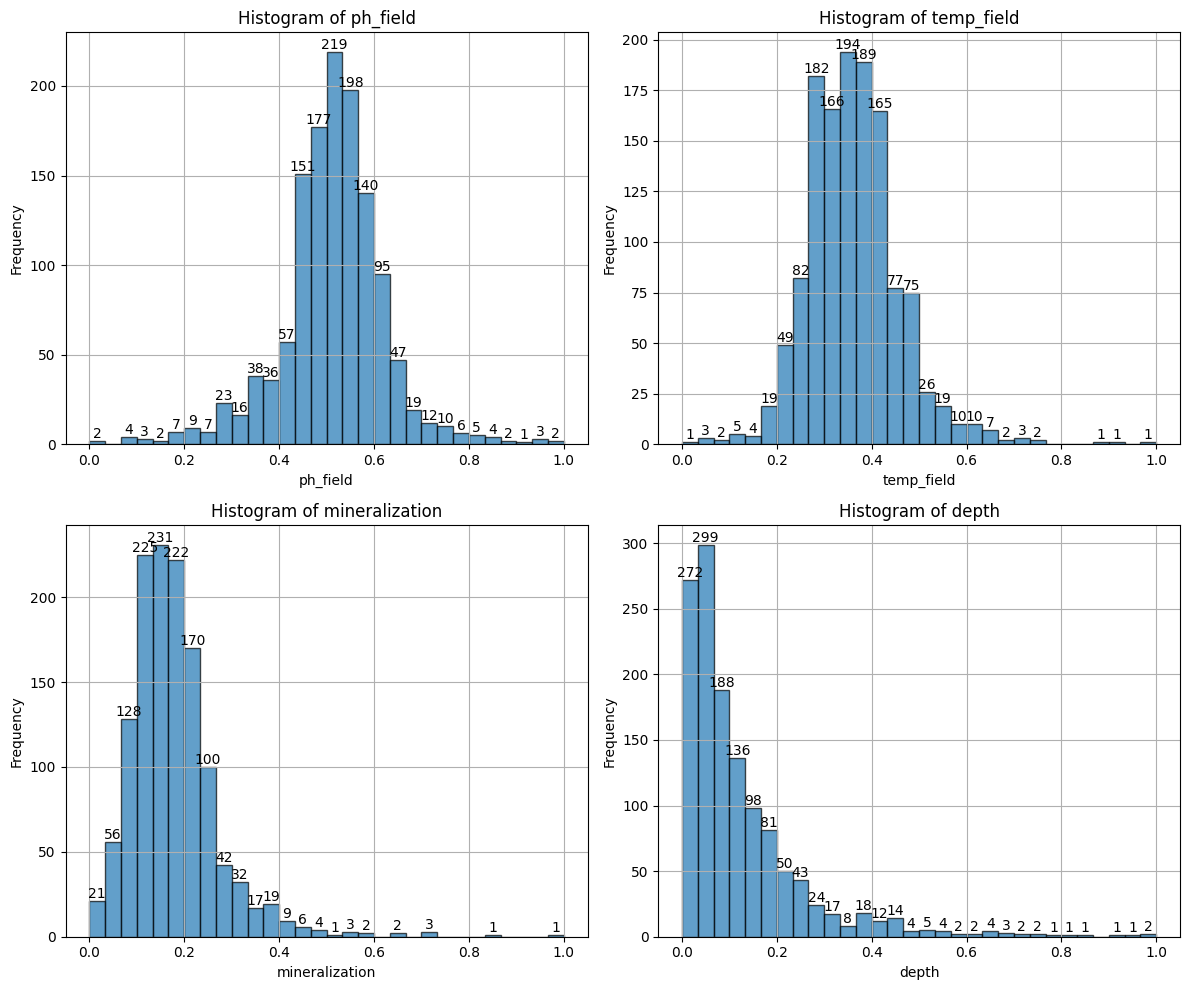

In [33]:
scaler = MinMaxScaler()

columns_to_scale = df_without_edge_values.columns
df_normalized_without_edge_values = pd.DataFrame(scaler.fit_transform(df_without_edge_values[columns_to_scale]), columns=columns_to_scale)

plot_histogram(df_normalized_without_edge_values)

## Dependency plots

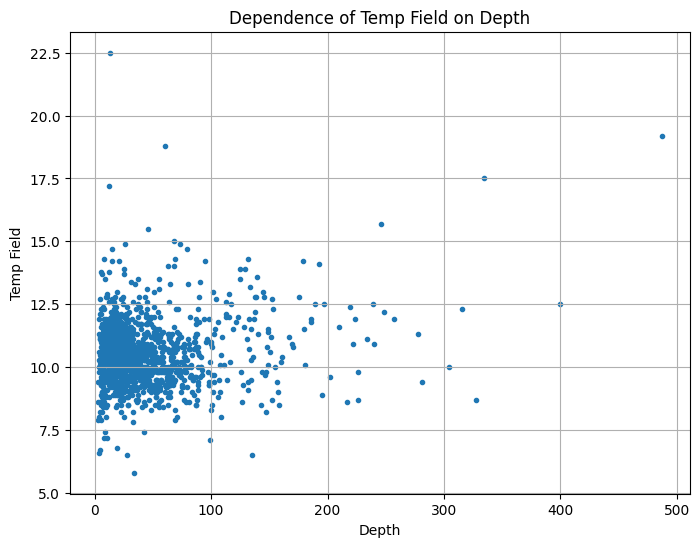

In [139]:
plt.figure(figsize=(8, 6))
plt.scatter(df_selected['depth'], df_selected['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

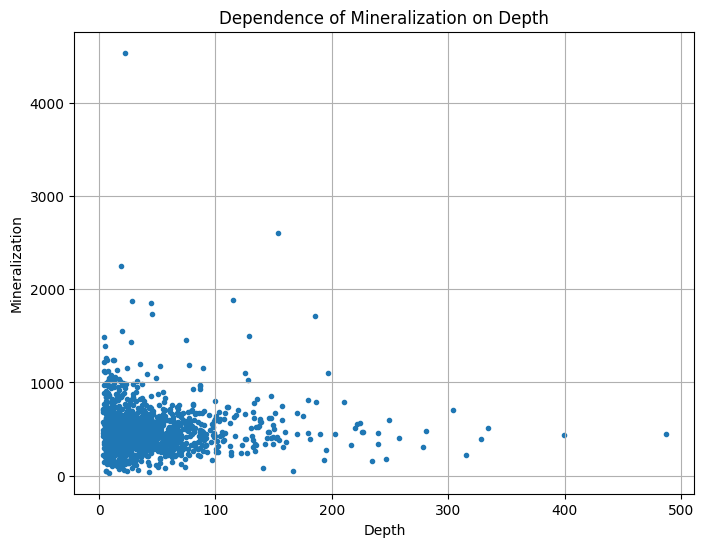

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(df_selected['depth'], df_selected['mineralization'], marker='.')
plt.title('Dependence of Mineralization on Depth')
plt.xlabel('Depth')
plt.ylabel('Mineralization')
plt.grid(True)
plt.show()

## Dependencies for data without most edge cases

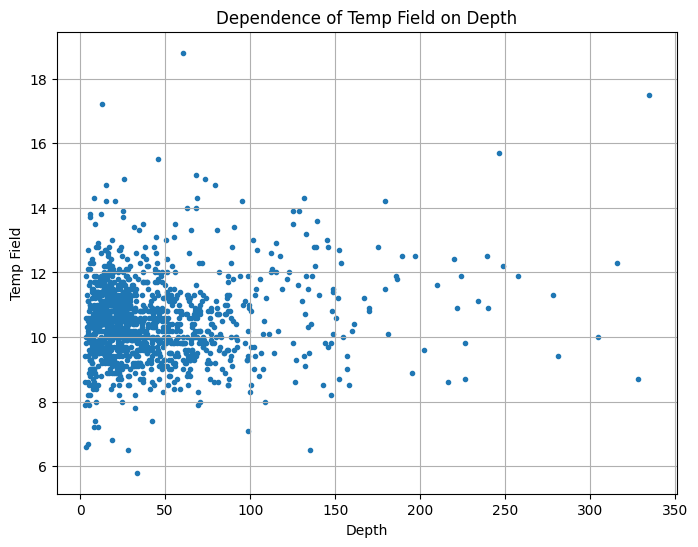

In [141]:
plt.figure(figsize=(8, 6))
plt.scatter(df_without_edge_values['depth'], df_without_edge_values['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

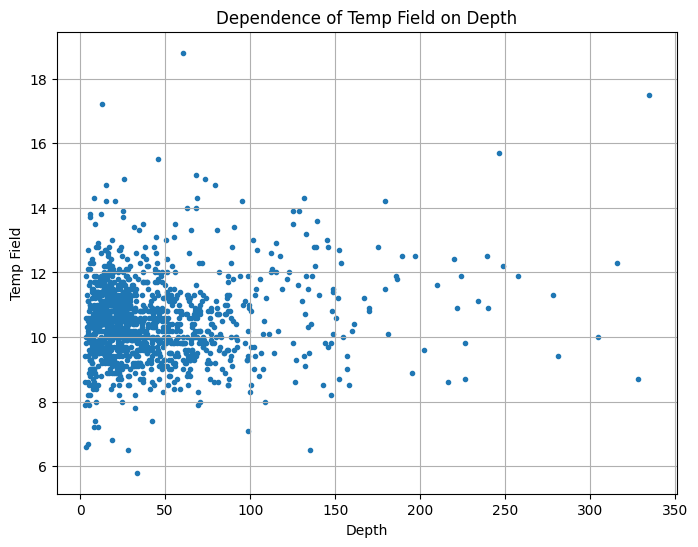

In [142]:
plt.figure(figsize=(8, 6))
plt.scatter(df_without_edge_values['depth'], df_without_edge_values['temp_field'], marker='.')
plt.title('Dependence of Temp Field on Depth')
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.grid(True)
plt.show()

In [155]:
additional_columns = ['City', 'Region', 'Latitude', 'Longitude']
df_normalized_without_edge_values_with_locations = pd.concat([df_normalized_without_edge_values, df_without_edge_values[additional_columns].reset_index(drop=True)], axis=1)

In [156]:
X = df_normalized_without_edge_values[['ph_field', 'temp_field', 'mineralization', 'depth']]
X.shape

(1295, 4)

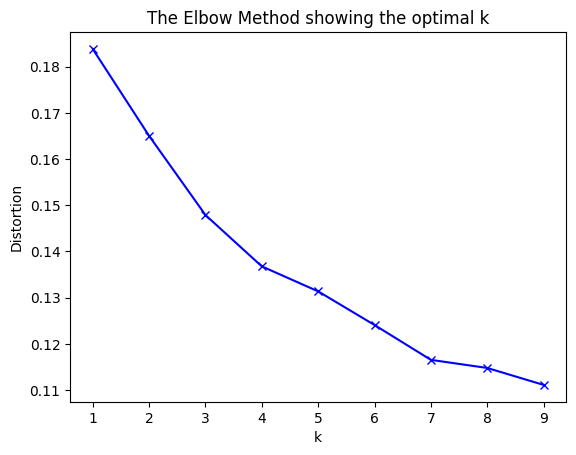

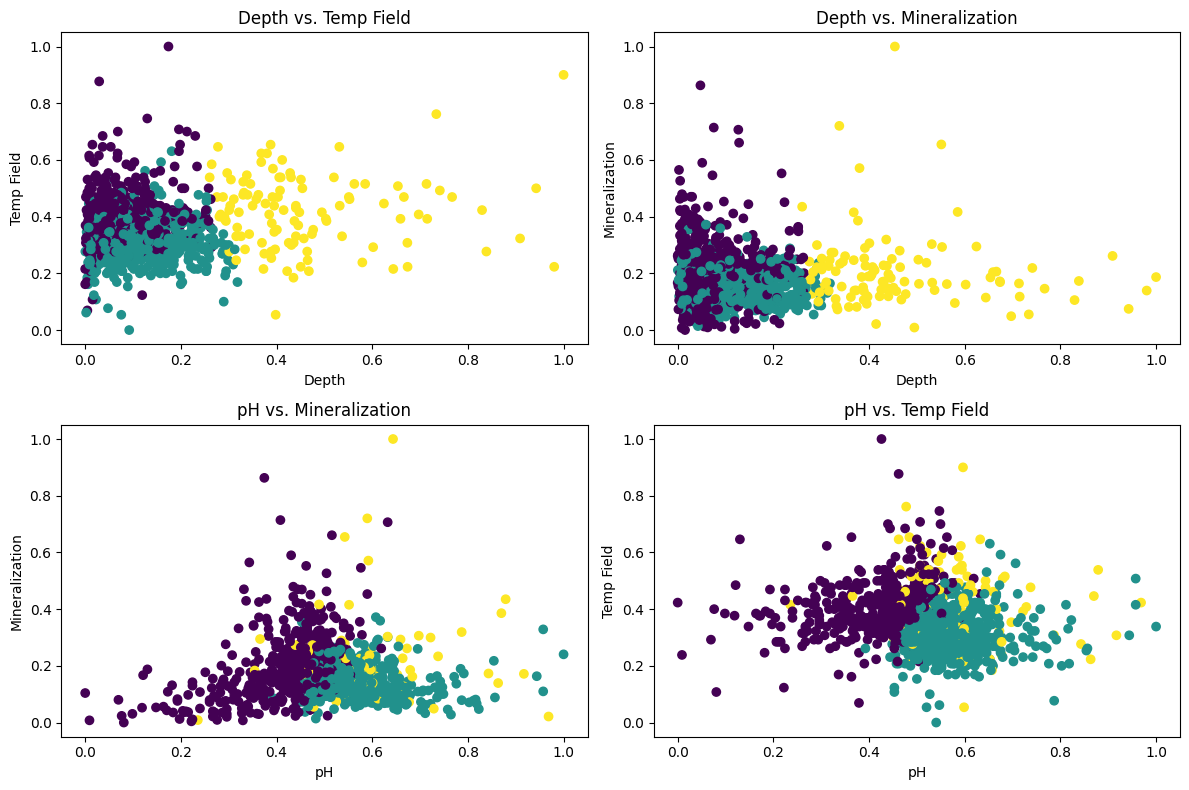

In [157]:
# prompt: use k-means method to do clasterization over these 4 parameters and show me that in 2D plots

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming df_normalized_without_edge_values is your preprocessed DataFrame
# Replace with your actual DataFrame if different



# Determine the optimal number of clusters (e.g., using the elbow method)
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow method
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# Choose the optimal k based on the elbow plot
optimal_k = 3  # Replace with your chosen k

# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)

df_normalized_w_locations_3 = df_normalized_without_edge_values_with_locations.copy()
df_normalized_w_locations_3['cluster'] = kmeans.fit_predict(X)

# Create 2D scatter plots for different pairs of features
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.title('Depth vs. Temp Field')

plt.subplot(2, 2, 2)
plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('Depth')
plt.ylabel('Mineralization')
plt.title('Depth vs. Mineralization')


plt.subplot(2, 2, 3)
plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('pH')
plt.ylabel('Mineralization')
plt.title('pH vs. Mineralization')

plt.subplot(2, 2, 4)
plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('pH')
plt.ylabel('Temp Field')
plt.title('pH vs. Temp Field')

plt.tight_layout()
plt.show()

In [158]:
df_normalized_w_locations_3.head()

,ph_field,temp_field,mineralization,depth,cluster,ph_class,City,Region,Latitude,Longitude
0,0.493274,0.453846,0.400885,0.033183,0,normal,Świnoujście,Świnoujście,53.904445,14.266023
1,0.504484,0.438462,0.190672,0.075415,0,normal,Świnoujście,Świnoujście,53.904445,14.266023
2,0.632287,0.453846,0.706616,0.126697,0,acid,Świnoujście,Świnoujście,53.904445,14.266023
3,0.576233,0.484615,0.545696,0.072700,0,acid,Świnoujście,Świnoujście,53.904445,14.266023
4,0.495516,0.323077,0.197102,0.075415,1,normal,Świnoujście,Świnoujście,53.904445,14.266023


In [159]:
import folium
from folium.plugins import MarkerCluster

poland_map = folium.Map(location=[52.2297, 21.0122], zoom_start=6)

# Initialize a MarkerCluster for better visualization of many points
# marker_cluster = MarkerCluster().add_to(poland_map)

# Define colors for clusters
cluster_colors = ['red', 'blue', 'yellow']  # Add more if needed

# Add markers for each record
for idx, row in df_normalized_w_locations_3.iterrows():
    cluster_id = row['cluster']  # Replace 'cluster' with your cluster column name
    color = cluster_colors[cluster_id % len(cluster_colors)]  # Assign color based on cluster ID
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Replace with your lat/lon column names
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(poland_map)

# Save and display the map
poland_map.save('poland_clusters_map.html')

C:\Users\oicmy\AppData\Local\Temp\ipykernel_54652\1877528400.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


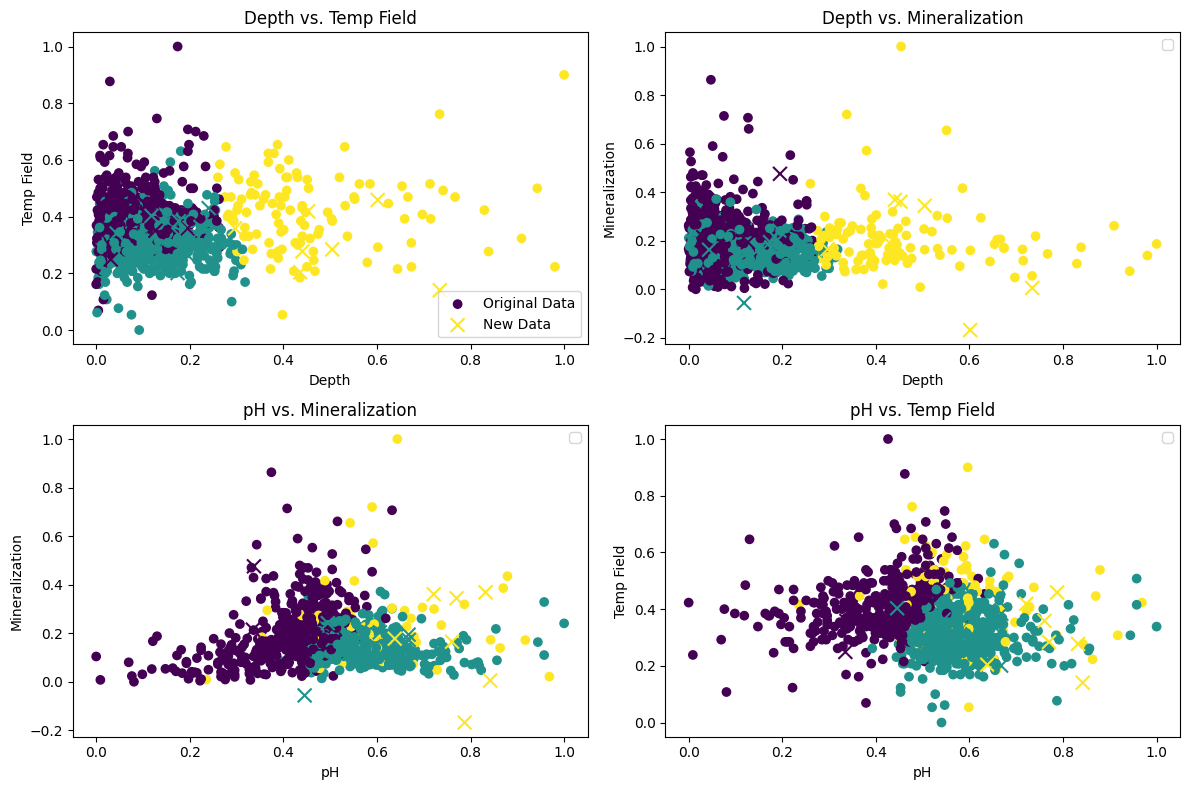

In [160]:
# Generate 20 new data points with similar values to existing data
# Assuming 'df_normalized_without_edge_values' contains your clustered data
new_data = []
for i in range(20):
    # Randomly select a cluster from the existing data
    cluster = np.random.choice(df_normalized_without_edge_values['cluster'].unique())

    # Get data points from the selected cluster
    cluster_data = df_normalized_without_edge_values[df_normalized_without_edge_values['cluster'] == cluster]

    # Sample from the means and std of each column
    new_point = {}
    for col in ['ph_field', 'temp_field', 'mineralization', 'depth']:
      new_point[col] = np.random.normal(cluster_data[col].mean(), cluster_data[col].std())
    new_data.append(new_point)


new_df = pd.DataFrame(new_data)

# Predict the clusters for the new data points
new_df['cluster'] = kmeans.predict(new_df)

# Create the plots
plt.figure(figsize=(12, 8))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    if i == 1:
        plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'], label='Original Data')
        plt.scatter(new_df['depth'], new_df['temp_field'], c=new_df['cluster'], marker='x', s=100, label='New Data')
        plt.xlabel('Depth')
        plt.ylabel('Temp Field')
        plt.title('Depth vs. Temp Field')
    elif i == 2:
        plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['depth'], new_df['mineralization'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('Depth')
        plt.ylabel('Mineralization')
        plt.title('Depth vs. Mineralization')
    elif i == 3:
        plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['ph_field'], new_df['mineralization'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('pH')
        plt.ylabel('Mineralization')
        plt.title('pH vs. Mineralization')
    elif i == 4:
        plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['ph_field'], new_df['temp_field'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('pH')
        plt.ylabel('Temp Field')
        plt.title('pH vs. Temp Field')

    plt.legend()

plt.tight_layout()
plt.show()

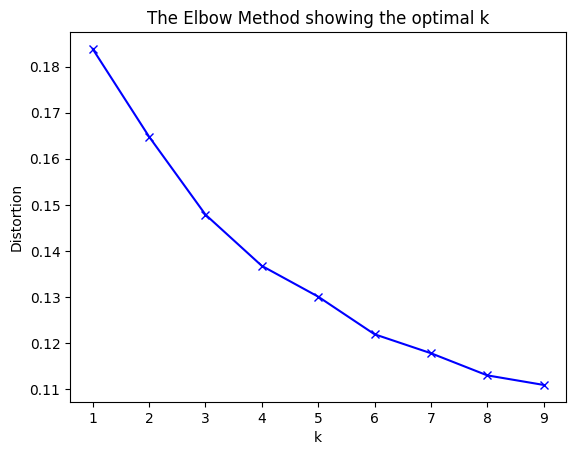

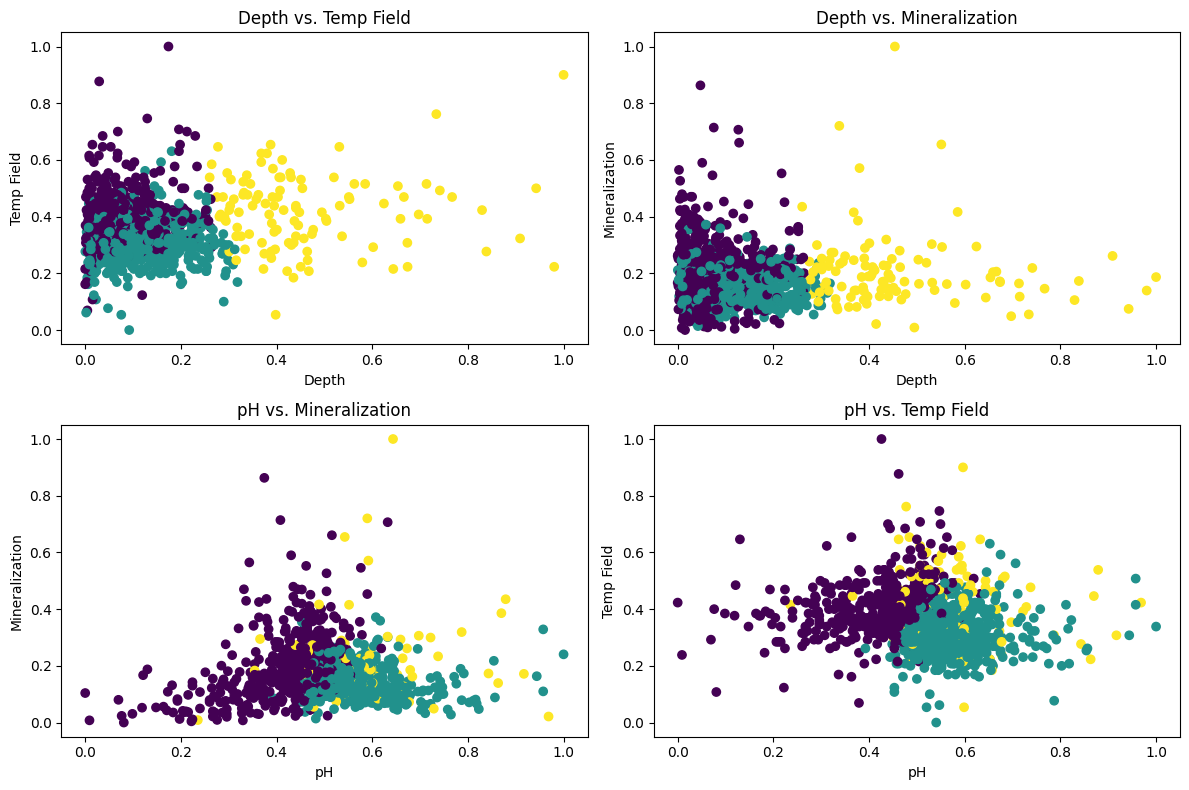

In [161]:
# prompt: use k-means method to do clasterization over these 4 parameters and show me that in 2D plots

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming df_normalized_without_edge_values is your preprocessed DataFrame
# Replace with your actual DataFrame if different

# Select the columns for clustering
X2 = df_normalized_without_edge_values[['ph_field', 'temp_field', 'mineralization', 'depth']]

# Determine the optimal number of clusters (e.g., using the elbow method)
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X2)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X2.shape[0])

# Plot the elbow method
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# Choose the optimal k based on the elbow plot
optimal_k = 5  # Replace with your chosen k

# Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)

df_normalized_w_locations_5 = df_normalized_without_edge_values_with_locations.copy()
df_normalized_w_locations_5['cluster'] = kmeans.fit_predict(X2)

# Create 2D scatter plots for different pairs of features
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('Depth')
plt.ylabel('Temp Field')
plt.title('Depth vs. Temp Field')

plt.subplot(2, 2, 2)
plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('Depth')
plt.ylabel('Mineralization')
plt.title('Depth vs. Mineralization')


plt.subplot(2, 2, 3)
plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('pH')
plt.ylabel('Mineralization')
plt.title('pH vs. Mineralization')

plt.subplot(2, 2, 4)
plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
plt.xlabel('pH')
plt.ylabel('Temp Field')
plt.title('pH vs. Temp Field')

plt.tight_layout()
plt.show()

In [165]:
poland_map = folium.Map(location=[52.2297, 21.0122], zoom_start=6)

# Initialize a MarkerCluster for better visualization of many points
# marker_cluster = MarkerCluster().add_to(poland_map)

# Define colors for clusters
cluster_colors = ['red', 'blue', 'yellow', 'green', 'purple']  # Add more if needed

# Add markers for each record
for idx, row in df_normalized_w_locations_5.iterrows():
    cluster_id = row['cluster']  # Replace 'cluster' with your cluster column name
    color = cluster_colors[cluster_id % len(cluster_colors)]  # Assign color based on cluster ID
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],  # Replace with your lat/lon column names
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
    ).add_to(poland_map)

# Save and display the map
poland_map.save('poland_clusters_map_5.html')

C:\Users\oicmy\AppData\Local\Temp\ipykernel_54652\240632254.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


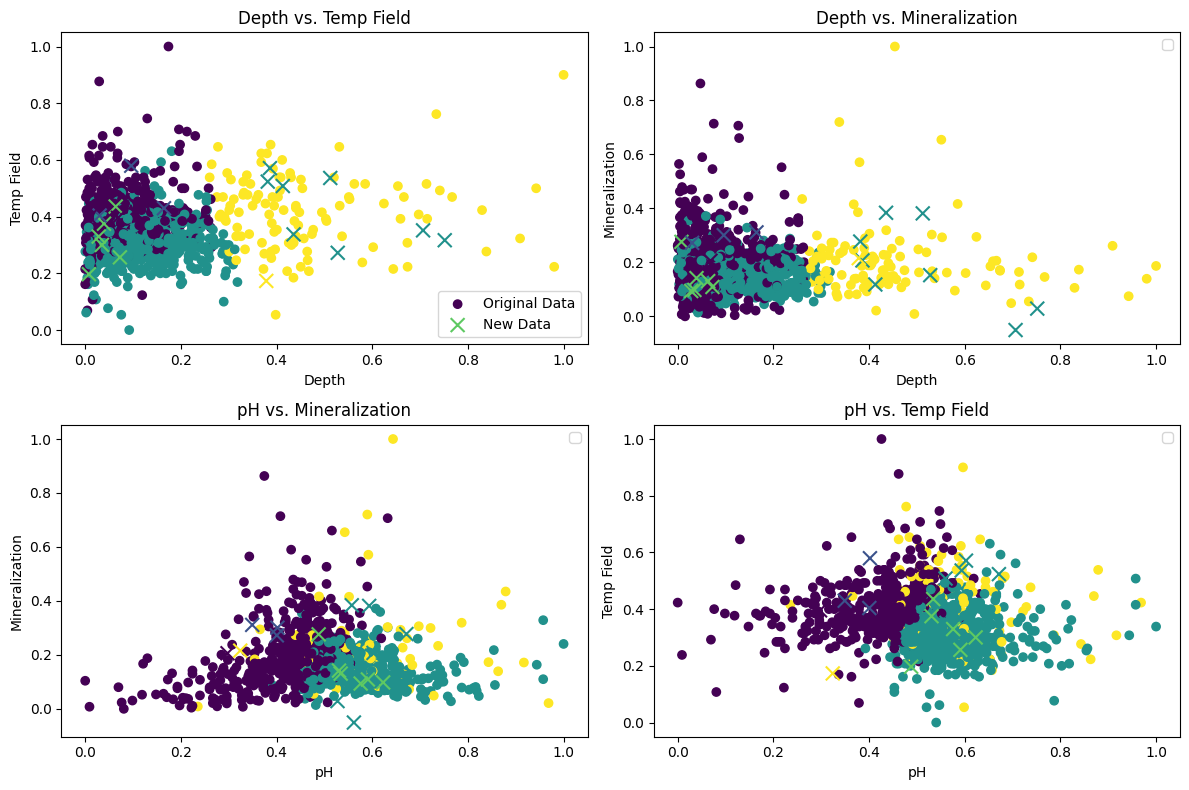

In [166]:
# prompt: generate 20 new points with similar values  and then classify them with diffrent mark on the overall plots, use same color for odequate clasters

import numpy as np

# Generate 20 new data points with similar values to existing data
# Assuming 'df_normalized_without_edge_values' contains your clustered data
new_data = []
for i in range(20):
    # Randomly select a cluster from the existing data
    cluster = np.random.choice(df_normalized_without_edge_values['cluster'].unique())

    # Get data points from the selected cluster
    cluster_data = df_normalized_without_edge_values[df_normalized_without_edge_values['cluster'] == cluster]

    # Sample from the means and std of each column
    new_point = {}
    for col in ['ph_field', 'temp_field', 'mineralization', 'depth']:
      new_point[col] = np.random.normal(cluster_data[col].mean(), cluster_data[col].std())
    new_data.append(new_point)


new_df = pd.DataFrame(new_data)

# Predict the clusters for the new data points
new_df['cluster'] = kmeans.predict(new_df)


# Create the plots
plt.figure(figsize=(12, 8))
for i in range(1, 5):
    plt.subplot(2, 2, i)
    if i == 1:
        plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'], label='Original Data')
        plt.scatter(new_df['depth'], new_df['temp_field'], c=new_df['cluster'], marker='x', s=100, label='New Data')
        plt.xlabel('Depth')
        plt.ylabel('Temp Field')
        plt.title('Depth vs. Temp Field')
    elif i == 2:
        plt.scatter(df_normalized_without_edge_values['depth'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['depth'], new_df['mineralization'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('Depth')
        plt.ylabel('Mineralization')
        plt.title('Depth vs. Mineralization')
    elif i == 3:
        plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['mineralization'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['ph_field'], new_df['mineralization'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('pH')
        plt.ylabel('Mineralization')
        plt.title('pH vs. Mineralization')
    elif i == 4:
        plt.scatter(df_normalized_without_edge_values['ph_field'], df_normalized_without_edge_values['temp_field'], c=df_normalized_without_edge_values['cluster'])
        plt.scatter(new_df['ph_field'], new_df['temp_field'], c=new_df['cluster'], marker='x', s=100)
        plt.xlabel('pH')
        plt.ylabel('Temp Field')
        plt.title('pH vs. Temp Field')

    plt.legend()

plt.tight_layout()
plt.show()

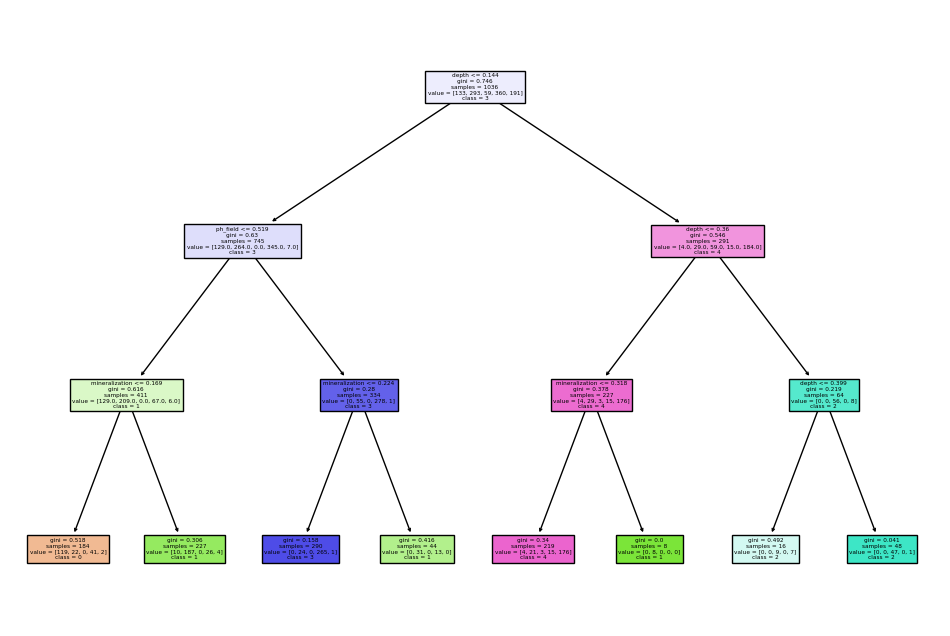

Latitude or longitude column not found in the DataFrame


<Figure size 1000x600 with 0 Axes>

In [129]:
# prompt: Create a decision tree for prection and show map

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming df_normalized_without_edge_values is your preprocessed DataFrame
# and 'cluster' column contains the cluster assignments

# Prepare the data for the decision tree
X = df_normalized_without_edge_values[['ph_field', 'temp_field', 'mineralization', 'depth']]
y = df_normalized_without_edge_values['cluster']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the decision tree classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Adjust max_depth as needed
clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=np.unique(y).astype('str'), filled=True)
plt.show()


#Create a map
import matplotlib.pyplot as plt

# Assuming you have a 'cluster' column and the coordinate data is in 'latitude' and 'longitude'

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 6))

# Assuming your data is in the df_normalized_without_edge_values DataFrame
if 'latitude' in df_normalized_without_edge_values.columns and 'longitude' in df_normalized_without_edge_values.columns:
    plt.scatter(df_normalized_without_edge_values['longitude'], df_normalized_without_edge_values['latitude'], c=df_normalized_without_edge_values['cluster'])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Cluster Map')
    plt.colorbar(label='Cluster')
    plt.show()
else:
    print("Latitude or longitude column not found in the DataFrame")

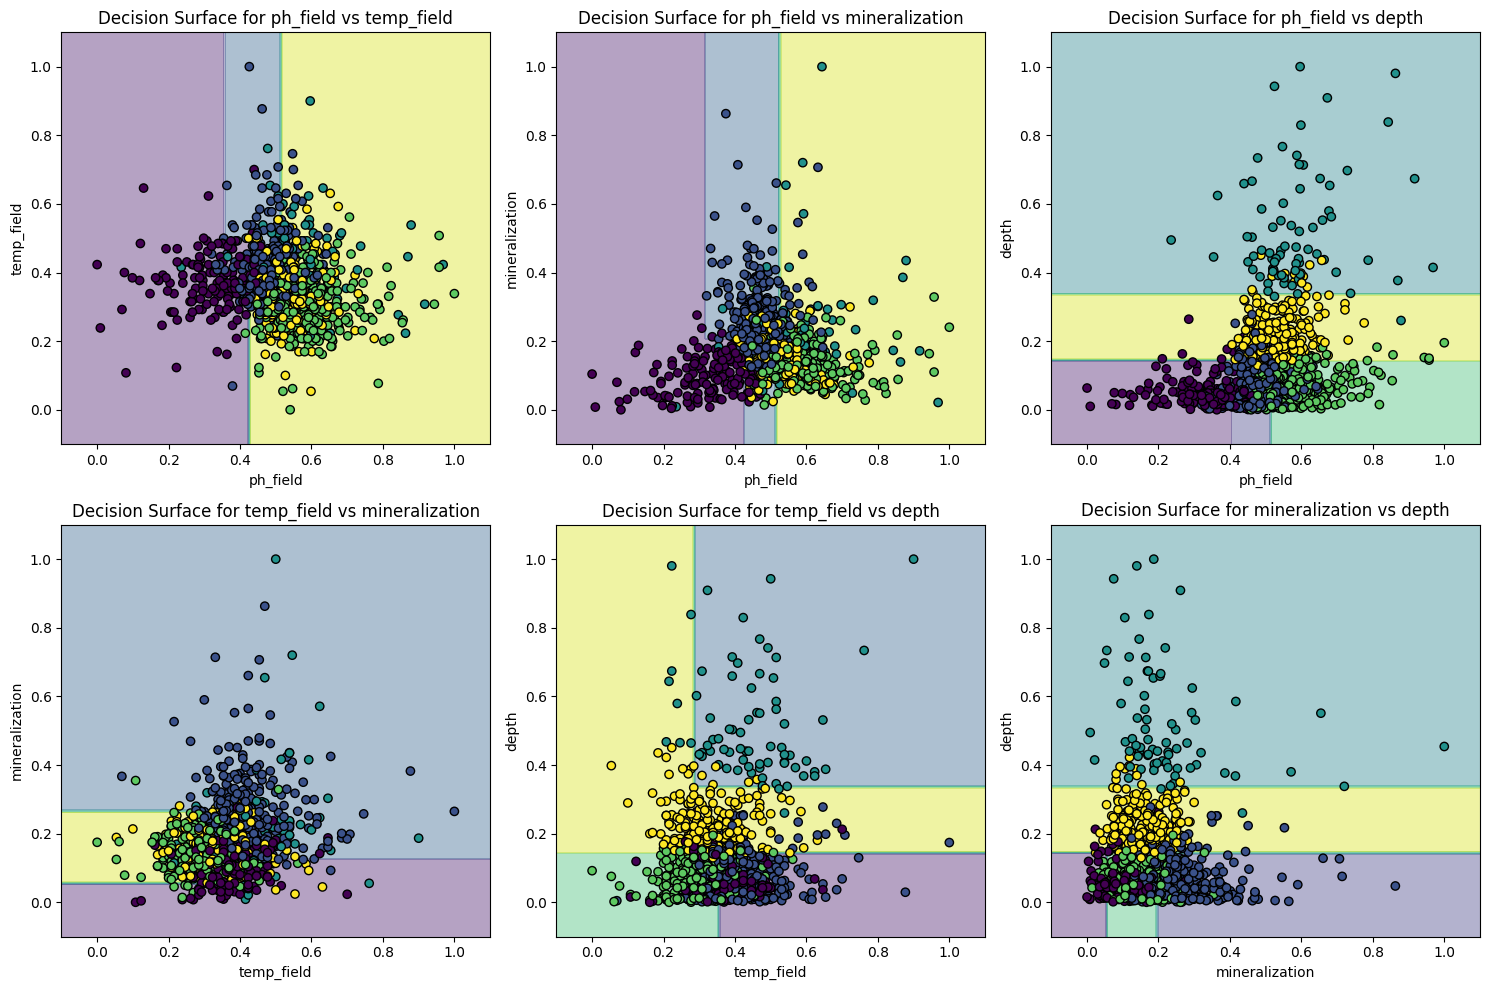

In [44]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# ... (Your existing code for data loading, preprocessing, and clustering)

# Assuming X and y are defined as before:
# X = df_normalized_without_edge_values[['ph_field', 'temp_field', 'mineralization', 'depth']]
# y = df_normalized_without_edge_values['cluster']

def plot_decision_surface(clf, X, y, feature_names, ax):
    # Create a meshgrid of feature values
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    # Predict cluster labels for the meshgrid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the decision surface on the provided axis
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(f"Decision Surface for {feature_names[0]} vs {feature_names[1]}")


# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figsize as needed

# Iterate through feature pairs and plot on subplots
feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2,3)]
for i, (f1, f2) in enumerate(feature_pairs):
  ax = axes[i // 3, i % 3] # index for subplots
  X_pair = X.values[:, [f1, f2]]
  clf_pair = DecisionTreeClassifier(max_depth=3, random_state=42)
  clf_pair.fit(X_pair, y)
  plot_decision_surface(clf_pair, X_pair, y, [X.columns[f1], X.columns[f2]], ax)


plt.tight_layout()
plt.show()

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Or DecisionTreeRegressor if predicting continuous pH
from sklearn.metrics import accuracy_score

# Assuming df_normalized_without_edge_values is your preprocessed DataFrame
# and it contains 'ph_field', 'temp_field', 'mineralization', 'depth', and 'real_class' columns

# Prepare the data
X = df_normalized_without_edge_values[['temp_field', 'depth', 'mineralization']]

# Create target variable based on pH classification
df_normalized_without_edge_values['ph_class'] = pd.cut(df_normalized_without_edge_values['ph_field'],
                                                      bins=[0, 0.45, 0.55, 1.0],
                                                      labels=['alkalite', 'normal', 'acid'],
                                                      include_lowest=True)
y = df_normalized_without_edge_values['ph_class']  # Target variable: pH class

# ----> Handle NaN values before splitting <----
# Drop rows with any NaN values in either X or y
df_cleaned = df_normalized_without_edge_values[['temp_field', 'depth', 'mineralization', 'ph_class']].dropna()
X = df_cleaned[['temp_field', 'depth', 'mineralization']]
y = df_cleaned['ph_class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier (to predict pH class)
classifier = DecisionTreeClassifier()  # Changed from regressor to classifier
classifier.fit(X_train, y_train)

# Predict pH classes for the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4864864864864865


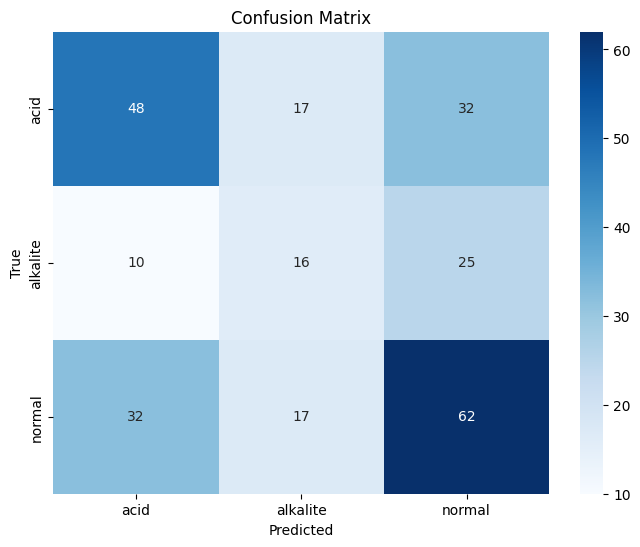

In [48]:
# prompt: create an acuracy matrix for ph predict

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_test and y_pred are defined from your previous code
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Or DecisionTreeRegressor if predicting continuous pH
from sklearn.metrics import accuracy_score

# Assuming df_normalized_without_edge_values is your preprocessed DataFrame
# and it contains 'ph_field', 'temp_field', 'mineralization', 'depth', and 'real_class' columns

# Prepare the data
X = df_selected[['temp_field', 'depth', 'mineralization']]

# Create target variable based on pH classification
df_selected['ph_class'] = pd.cut(df_selected['ph_field'],
                                                      bins=[0, 6.8, 7.2, 10],
                                                      labels=['acid', 'normal', 'alkalite'],
                                                        include_lowest=True)
y = df_selected['ph_class']  # Target variable: pH class

# ----> Handle NaN values before splitting <----
# Drop rows with any NaN values in either X or y
df_cleaned = df_selected[['temp_field', 'depth', 'mineralization', 'ph_class']].dropna()
X = df_cleaned[['temp_field', 'depth', 'mineralization']]
y = df_cleaned['ph_class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier (to predict pH class)
classifier = DecisionTreeClassifier()  # Changed from regressor to classifier
classifier.fit(X_train, y_train)

# Predict pH classes for the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5038461538461538


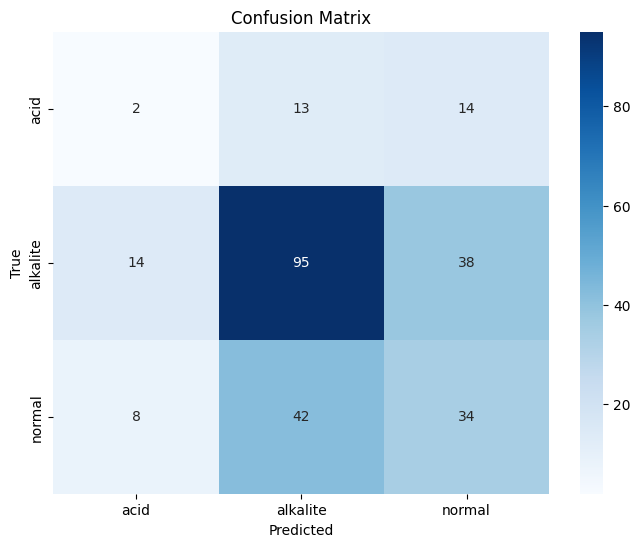

In [50]:
# prompt: create an acuracy matrix for ph predict

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_test and y_pred are defined from your previous code
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [51]:
new_df.head()

,ph_field,temp_field,mineralization,depth,cluster
0,0.339120,0.508196,0.032952,0.077810,0
1,0.565516,0.339526,0.536195,0.526074,2
2,0.600898,0.313884,0.213990,0.264739,4
3,0.146264,0.420808,0.106287,-0.026126,0
4,0.452140,0.344447,0.143569,0.032840,3
